# Building/wrangling the dataframe

In this notebook, I retrieve SpaceX launch data from the SpaceX API and by webscraping Wikipedia. Then, I wrangle and examine the data statistically. Next, I perform some database queries and analyze the launch sites using Folium. Finally, I train ML models to predict when a landing will be succesful.

In [29]:
import requests
import pandas as pd
import numpy as np
import json
import datetime
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [3]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [180]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
#print(response.content)

In [29]:
response.status_code

200

In [269]:
# Use json_normalize meethod to convert the json result into a dataframe
response = requests.get(spacex_url)
j = response.json()
data = pd.json_normalize(j)

In [31]:
# Get the head of the dataframe
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

In [270]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [271]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [272]:
# Call getBoosterVersion
getBoosterVersion(data)

In [273]:
# check that it worked
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [274]:
# do the rest
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [275]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [276]:
# Create a data from launch_dict
df=pd.DataFrame.from_dict(launch_dict)
# Show the head of the dataframe
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [278]:
# keep only falcon 9
data_falcon9=df[df['BoosterVersion']!='Falcon 1']
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,102,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,103,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,104,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,105,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [43]:
# reset flight number
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

C:\Users\sepul\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [44]:
# check missing values
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [45]:
# Calculate the mean value of PayloadMass column
mn=data_falcon9['PayloadMass'].mean()
print(mn)

6123.547647058824


In [47]:
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass']=data_falcon9['PayloadMass'].replace(np.nan,mn)
data_falcon9.isnull().sum()

<ipython-input-47-39abcc66435b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass']=data_falcon9['PayloadMass'].replace(np.nan,mn)


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [83]:
# percent of missing values in each attribute
df = data_falcon9
df.isnull().sum()/df.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
Class              0.000000
year               0.000000
dtype: float64

In [52]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [53]:
# number of launches per site
df['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [55]:
# per orbit
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
GEO       1
SO        1
ES-L1     1
HEO       1
Name: Orbit, dtype: int64

In [58]:
# landing outcomes
landing_outcomes=df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [61]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])

In [62]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class=[]
for i in df['Outcome']:
    if i not in bad_outcomes:
        landing_class.append(1)
    else:
        landing_class.append(0)

In [64]:
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0
9,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1005,-80.577366,28.561857,0
10,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006,-80.577366,28.561857,1
11,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007,-80.577366,28.561857,1
12,9,2014-08-05,Falcon 9,4535.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1008,-80.577366,28.561857,0
13,10,2014-09-07,Falcon 9,4428.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1011,-80.577366,28.561857,0


In [65]:
# success rate
df["Class"].mean()

0.6666666666666666

# Webscraping

In [173]:
import sys

from bs4 import BeautifulSoup
import re
import unicodedata

In [33]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

In [174]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

data=requests.get(static_url).text 

soup=BeautifulSoup(data)

print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [60]:
html_tables=[]
for i in soup.find_all('tr'):
    html_tables.append(i)

In [61]:
first_launch_table = html_tables[2]
print(first_launch_table)

<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>


In [62]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
for i in first_launch_table.find_all('th'):
    name=extract_column_from_header(i)
    if name is not None and len(name)>0:
        column_names.append(name)

In [63]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [74]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [75]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            #print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            #print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            #print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            #print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            #print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            #print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a is not None:
                customer = row[6].a.string
            else:
                customer = "Various"
            launch_dict['Customer'].append(customer)
            #print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            #print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            #print(booster_landing)

In [175]:
dffromsoup=pd.DataFrame(launch_dict)

dffromsoup.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


In [80]:
months={"January": "1", "February": "2", "March": "3", "April": "4", "May": "5", "June": "6", "July": "7", "August": "8", "September": "9", "October": "10", "November": "11", "December": "12"}
newdates=[]
for index, row in dffromsoup.iterrows():
    for month in months:
        if month in row['Date']:
            mo=months[month]
    da=str(row['Date'][0:2])
    yr=str(row['Date'][len(row['Date'])-4:len(row['Date'])])
    newdate= yr + "-"+ mo + "-" + da
    newdates.append(newdate)

In [81]:
dffromsoup['Date']=newdates

In [100]:
dffromsoup = dffromsoup.rename(columns={'Flight No.':'FlightNo', 'Launch site':'Launchsite', 'Payload':'Payload', 'Payload mass':'Payloadmass', 'Orbit':'Orbit', 'Customer': 'Customer', 'Launch outcome': 'Launchoutcome', 'Version Booster': 'VersionBooster', 'Booster landing': 'Boosterlanding', 'Date': 'Date', 'Time': 'Time'})

In [157]:
for index, row in dffromsoup.iterrows():
    if "kg" in str(row['Payloadmass']):
        row['Payloadmass'] = str(row['Payloadmass']).replace("kg","")
    if "~" in str(row['Payloadmass']):
        row['Payloadmass'] = str(row['Payloadmass']).replace("~","")
    if "," in str(row['Payloadmass']):
        row['Payloadmass'] = str(row['Payloadmass']).replace(",","")
    if "C" in str(row['Payloadmass']):
        row['Payloadmass'] = 0
    if "–" in str(row['Payloadmass']):
        row['Payloadmass'] = 5500

In [ ]:
dffromsoup = dffromsoup.astype({'Payloadmass': 'int'})

In [178]:
dffromsoup

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1,Success,3 June 2021,17:29


Now it is ready for querying. We can also export it here for use with a dash application.

In [179]:
dffromsoup.to_csv('spacex_launch_dash.csv', index=False)

# Premature analysis

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

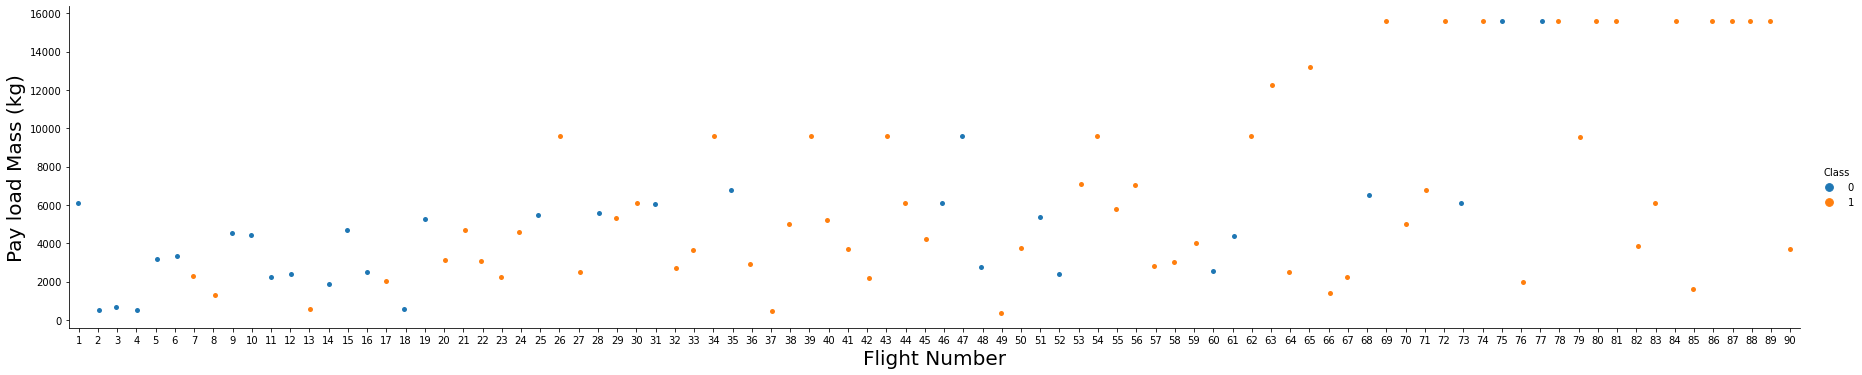

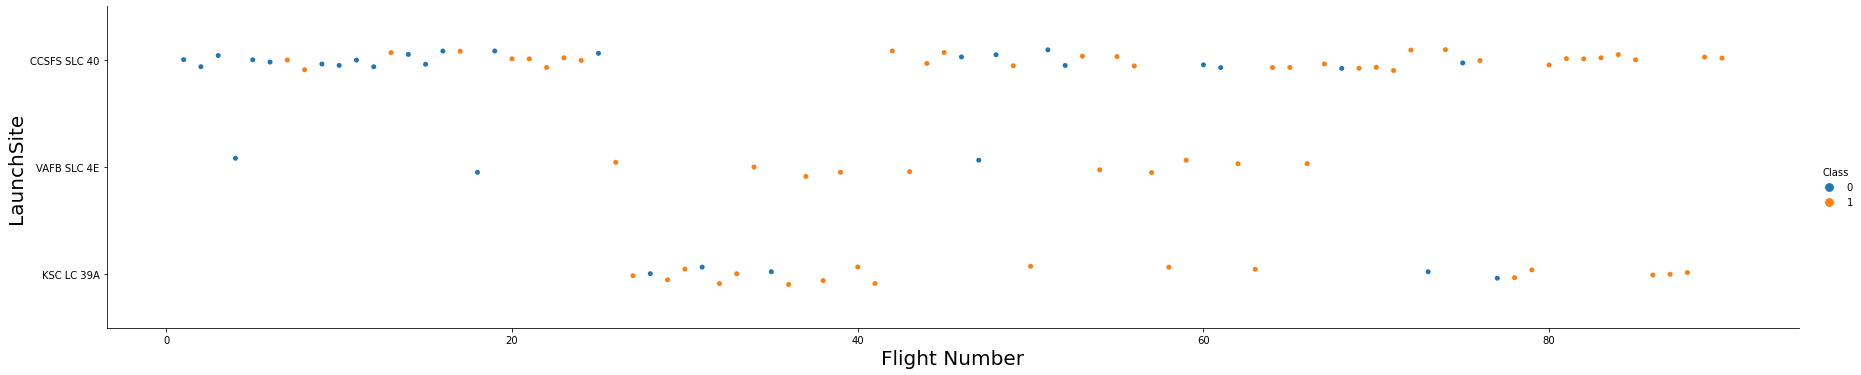

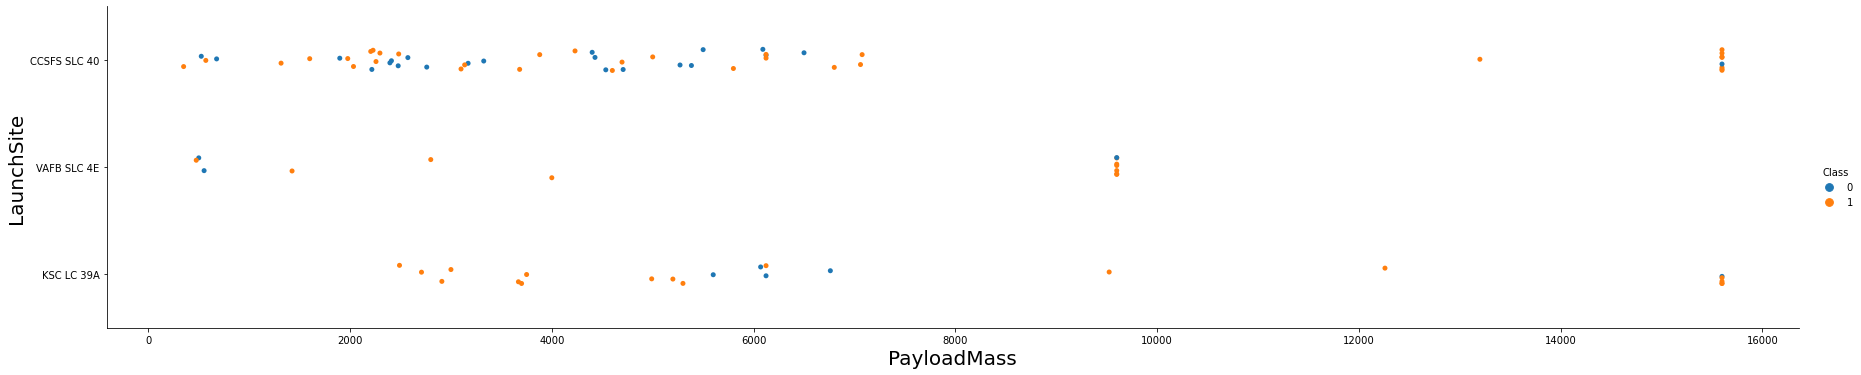

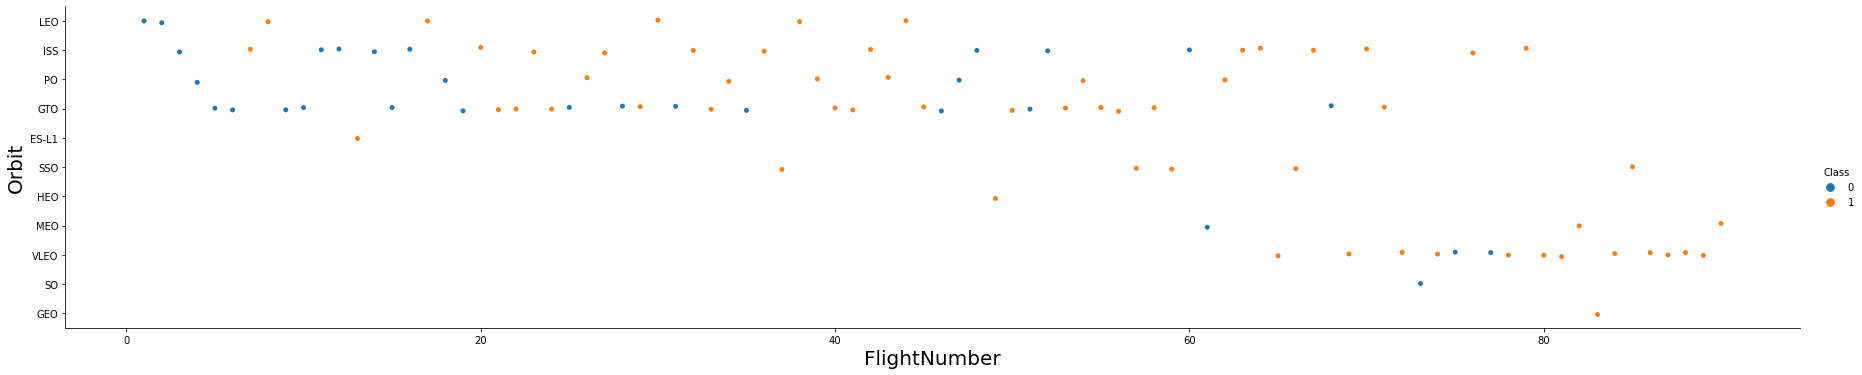

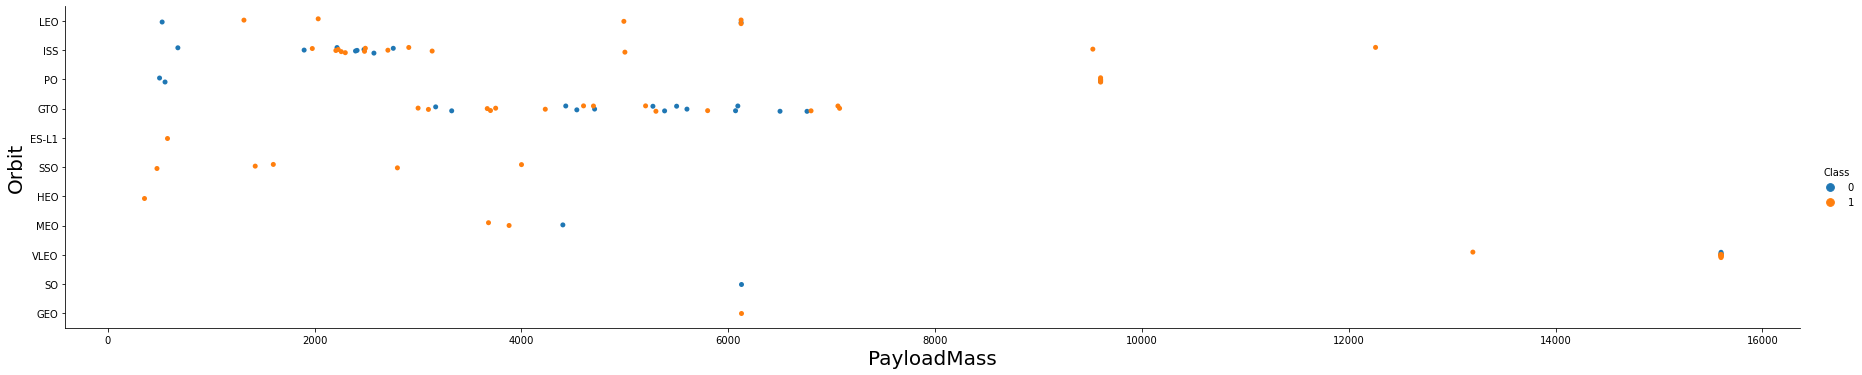

In [70]:
# some insightful scatterplots
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

<AxesSubplot:xlabel='Orbit'>

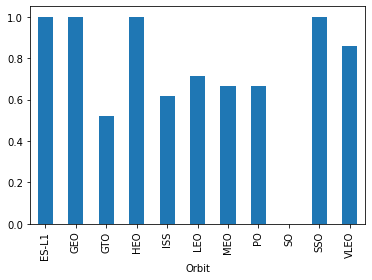

In [71]:
# success rate per orbit
df.groupby(['Orbit'])['Class'].mean().plot.bar()

<AxesSubplot:xlabel='year'>

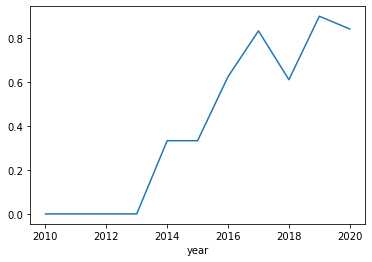

In [82]:
# yearly success rate
df2=df
df2['year'] = pd.DatetimeIndex(df2['Date']).year

df2.groupby(['year'])['Class'].mean().plot()

In [84]:
# new dataframe with most desired attributes as indicated by above exploration
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [88]:
# onehotencoder-ing the dataframe
features_one_hot=pd.get_dummies(features,columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
features_one_hot.astype('float64').head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Folium Analysis

#### just for fun

In [31]:
!pip install folium
import folium

In [94]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [99]:
# launch site coordinates
spacex_df = df[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df

,LaunchSite,Latitude,Longitude
0,CCSFS SLC 40,28.561857,-80.577366
1,KSC LC 39A,28.608058,-80.603956
2,VAFB SLC 4E,34.632093,-120.610829


In [102]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [103]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [105]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for i,r in launch_sites_df.iterrows():
    crcl=folium.Circle([r['Latitude'],r['Longitude']], radius=1000, color='#d35400', fill=True).add_child(folium.Popup(r['LaunchSite']))
    mrkr=folium.map.Marker([r['Latitude'],r['Longitude']],icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0),html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % r['LaunchSite'],))
    site_map.add_child(crcl)
    site_map.add_child(mrkr)
site_map

In [111]:
marker_cluster = MarkerCluster()
# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red
marker_color=[]
for i,r in spacex_df.iterrows():
    if r['Class']==1:
        marker_color.append('green')
    else:
        marker_color.append('red')
spacex_df['marker_color']=marker_color
spacex_df.tail(10)

<ipython-input-111-beb28855e461>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['marker_color']=marker_color


,LaunchSite,Latitude,Longitude,Class,marker_color
84,CCSFS SLC 40,28.561857,-80.577366,1,green
85,CCSFS SLC 40,28.561857,-80.577366,1,green
86,CCSFS SLC 40,28.561857,-80.577366,1,green
87,CCSFS SLC 40,28.561857,-80.577366,1,green
88,CCSFS SLC 40,28.561857,-80.577366,1,green
89,KSC LC 39A,28.608058,-80.603956,1,green
90,KSC LC 39A,28.608058,-80.603956,1,green
91,KSC LC 39A,28.608058,-80.603956,1,green
92,CCSFS SLC 40,28.561857,-80.577366,1,green
93,CCSFS SLC 40,28.561857,-80.577366,1,green


In [112]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    # TODO: Create and add a Marker cluster to the site map
    # marker = folium.Marker(...)
    marker=folium.Marker([record['Latitude'],record['Longitude']],icon=folium.Icon(color='white', icon_color=record['marker_color']))
    marker_cluster.add_child(marker)

site_map

In [113]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [114]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [115]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
launch_site_lat, launch_site_lon, coastline_lat, coastline_lon = 28.56322,-80.57681,28.56369,-80.56807
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

In [116]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline)
        )
    )

In [117]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
lines=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=10,color='blue')
site_map.add_child(lines)

In [118]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site
launch_site_lat, launch_site_lon, coastline_lat, coastline_lon = 28.56322,-80.57681,28.57207,-80.58523
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline)
        )
    )
lines=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=10,color='green')
site_map.add_child(lines)

It makes sense that launch sites are far from cities but near a railway/highway/coastline. Launches often land in water, and transit lines probably need to be nearby to quickly move supplies as needed. But cities (and residents) are a liability.

# Database queries with SQL

In [84]:
!pip install ipython-sql

In [85]:
%load_ext sql

In [86]:
import sqlite3

In [87]:
con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [88]:
%sql sqlite:///my_data1.db

In [161]:
# df from webscraping
dffromsoup.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

In [104]:
#%sql alter table SPACEXTBL add column Date2

In [105]:
#%sql update SPACEXTBL set Date2=substr(Date,7,4)||'-'||substr(Date,4,2)||'-'||substr(Date,1,2)

In [162]:
%sql select * from SPACEXTBL limit 10

 * sqlite:///my_data1.db
Done.


FlightNo,Launchsite,Payload,Payloadmass,Orbit,Customer,Launchoutcome,VersionBooster,Boosterlanding,Date,Time
1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,2010-6-4,18:45
2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,2010-12-8,15:43
3,CCAFS,Dragon,525,LEO,NASA,Success,F9 v1.0B0005.1,No attempt,2012-5-22,07:44
4,CCAFS,SpaceX CRS-1,4700,LEO,NASA,Success,F9 v1.0B0006.1,No attempt,2012-10-8,00:35
5,CCAFS,SpaceX CRS-2,4877,LEO,NASA,Success,F9 v1.0B0007.1,No attempt,2013-3-1,15:10
6,VAFB,CASSIOPE,500,Polar orbit,MDA,Success,F9 v1.1B1003,Uncontrolled,2013-9-29,16:00
7,CCAFS,SES-8,3170,GTO,SES,Success,F9 v1.1,No attempt,2013-12-3,22:41
8,CCAFS,Thaicom 6,3325,GTO,Thaicom,Success,F9 v1.1,No attempt,2014-1-6,22:06
9,Cape Canaveral,SpaceX CRS-3,2296,LEO,NASA,Success,F9 v1.1,Controlled,2014-4-18,19:25
10,Cape Canaveral,Orbcomm-OG2,1316,LEO,Orbcomm,Success,F9 v1.1,Controlled,2014-7-14,15:15


In [163]:
# distinct launch sites
%sql select distinct(Launchsite) from SPACEXTBL

 * sqlite:///my_data1.db
Done.


Launchsite
CCAFS
VAFB
Cape Canaveral
KSC
CCSFS


In [164]:
# first 5 CCA entries
%sql select * from SPACEXTBL where Launchsite like 'CCA%' limit 5

 * sqlite:///my_data1.db
Done.


FlightNo,Launchsite,Payload,Payloadmass,Orbit,Customer,Launchoutcome,VersionBooster,Boosterlanding,Date,Time
1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,2010-6-4,18:45
2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,2010-12-8,15:43
3,CCAFS,Dragon,525,LEO,NASA,Success,F9 v1.0B0005.1,No attempt,2012-5-22,07:44
4,CCAFS,SpaceX CRS-1,4700,LEO,NASA,Success,F9 v1.0B0006.1,No attempt,2012-10-8,00:35
5,CCAFS,SpaceX CRS-2,4877,LEO,NASA,Success,F9 v1.0B0007.1,No attempt,2013-3-1,15:10


In [166]:
# total payload carried by nasa projects
%sql select sum(Payloadmass) from SPACEXTBL where Customer = 'NASA'

 * sqlite:///my_data1.db
Done.


sum(Payloadmass)
124708


In [169]:
# average payload
%sql select avg(Payloadmass) from SPACEXTBL where VersionBooster = 'F9 v1.1'

 * sqlite:///my_data1.db
Done.


avg(Payloadmass)
2680.0


In [113]:
# date of first success
%sql select min(Date) from SPACEXTBL where Boosterlanding like 'Success%' limit 1

 * sqlite:///my_data1.db
Done.


min(Date)
2015-12-22


In [171]:
# successful boosters with payload between 4000-6000
%sql select * from SPACEXTBL where Payloadmass<6000 and Payloadmass>4000 and Boosterlanding like 'Success%'

 * sqlite:///my_data1.db
Done.


FlightNo,Launchsite,Payload,Payloadmass,Orbit,Customer,Launchoutcome,VersionBooster,Boosterlanding,Date,Time
24,Cape Canaveral,JCSAT-14,4696,GTO,SKY Perfect JSAT Group,Success,F9 FT,Success,2016-5-6,05:21
28,Cape Canaveral,JCSAT-16,4600,GTO,SKY Perfect JSAT Group,Success,F9 FT,Success,2016-8-14,05:26
32,KSC,SES-10,5300,GTO,SES,Success,F9 FT♺,Success,2017-3-30,22:27
41,KSC,Boeing X-37B,4990,LEO,USAF,Success,F9 B4,Success,2017-9-7,14:00
43,KSC,SES-11,5200,GTO,SES S.A.,Success,F9 FTB1031.2,Success,2017-10-11,22:53:00
60,CCAFS,Merah Putih,5800,GTO,Telkom Indonesia,Success,F9 B5B1046.2,Success,2018-8-7,05:18
63,KSC,Es'hail 2,5300,GTO,Es'hailSat,Success,F9 B5B1047.2,Success,2018-11-15,20:46
68,CCAFS,Nusantara Satu,4850,GTO,PSN,Success,F9 B5B1048.3,Success,2019-2-22,01:45
72,VAFB,RADARSAT Constellation,4200,SSO,Canadian Space Agency,Success,F9 B5B1051.2,Success,2019-6-12,14:17
88,CCAFS,GPS III,4311,MEO,U.S. Space Force,Success,F9 B5,Success,2020-6-30,20:10:46


In [115]:
# total successful
%sql select count(*) from SPACEXTBL where Launchoutcome like 'Success%'

 * sqlite:///my_data1.db
Done.


count(*)
120


In [117]:
# and failed
%sql select count(*) from SPACEXTBL where Launchoutcome like 'Failure%'

 * sqlite:///my_data1.db
Done.


count(*)
1


In [172]:
# boosters with max payload
%sql select VersionBooster from SPACEXTBL where Payloadmass=(select max(Payloadmass) from SPACEXTBL)

 * sqlite:///my_data1.db
Done.


VersionBooster
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5B1060.2
F9 B5B1058.3
F9 B5B1051.6


In [127]:
# 2015 data
%sql select Date,Boosterlanding,VersionBooster,Launchsite from SPACEXTBL where substr(Date,1,4)='2015' and Boosterlanding like 'Failure'

 * sqlite:///my_data1.db
Done.


Date,Boosterlanding,VersionBooster,Launchsite
2015-4-14,Failure,F9 v1.1,Cape Canaveral


In [126]:
# landing outcomes between 2010-06-04 and 2017-03-20
%sql select Boosterlanding, count(*) from SPACEXTBL where Date between '2010-06-04' and '2017-03-20' group by Boosterlanding order by count(*) desc

 * sqlite:///my_data1.db
Done.


Boosterlanding,count(*)
Success,6
No attempt,6
Failure,6
No attempt,3
Controlled,3
Uncontrolled,2
Precluded,1
Failure,1


# Machine Learning

In [197]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [198]:
# confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [202]:
data = df
X = features_one_hot.astype('float64')
X.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
Y=data['Class']
Y=Y.to_numpy()

In [204]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(X)
print(X)

[[-1.71291154  0.         -0.65391284 ... -0.21566555 -0.18569534
  -0.10599979]
 [-1.67441914 -1.18972425 -0.65391284 ... -0.21566555 -0.18569534
  -0.10599979]
 [-1.63592675 -1.15742336 -0.65391284 ... -0.21566555 -0.18569534
  -0.10599979]
 ...
 [ 1.63592675  2.01380177  3.49060516 ... -0.21566555 -0.18569534
  -0.10599979]
 [ 1.67441914  2.01380177  1.00389436 ... -0.21566555  5.38516481
  -0.10599979]
 [ 1.71291154 -0.51905572 -0.65391284 ... -0.21566555 -0.18569534
   9.43398113]]


In [205]:
# splitting train/test data
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

In [206]:
Y_test.shape

(18,)

### Logistic Regression

In [207]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv=GridSearchCV(estimator=lr,param_grid=parameters,cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [208]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [209]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

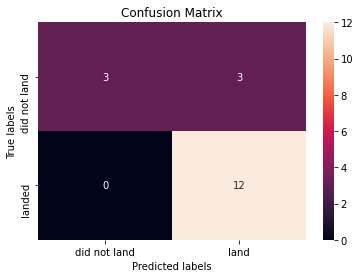

In [210]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

This model has problem with false positives

### SVM

In [211]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv=GridSearchCV(svm,parameters,cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [212]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [213]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

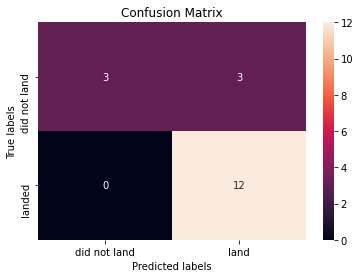

In [214]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision Tree

In [216]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv=GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [217]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8732142857142856


In [218]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

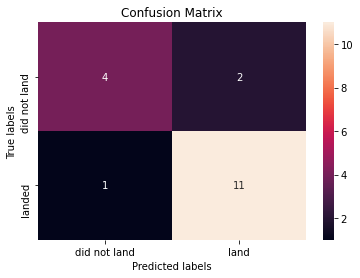

In [219]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### KNN

In [220]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv=GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [221]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [222]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

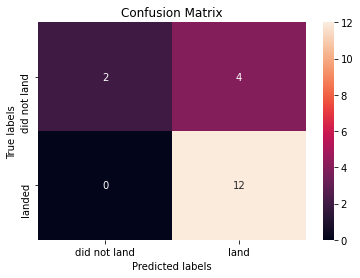

In [223]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

As we can see from the results of testing our models, all models had an accuracy of roughly 83 percent, and identical confusion matrix that indicates the models have trouble with false positives. However, I noticed that the results of testing the tree model in particular seemed to depend heavily on the training and testing data, as the accuracy and confusion matrix seem to vary significantly each time the notebook is reran. To eliminate ambiguity, we train/test the data many times and use the average.

0.8738571428571427
0.7827777777777777


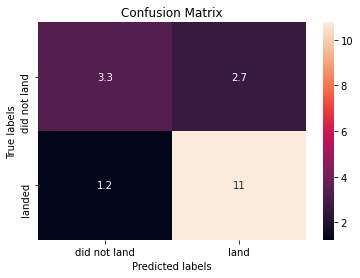

In [224]:
from sklearn.metrics import confusion_matrix
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
avgtrainscore=0
avgtestscore=0
avgcmatrix00=0
avgcmatrix01=0
avgcmatrix10=0
avgcmatrix11=0
for i in range(100):
    X_train0, X_test0, Y_train0, Y_test0=train_test_split(X,Y,test_size=0.2,random_state=2)
    tree_cv=GridSearchCV(tree,parameters,cv=10)
    tree_cv.fit(X_train0, Y_train0)
    avgtrainscore+=tree_cv.best_score_/100
    avgtestscore+=tree_cv.score(X_test0, Y_test0)/100
    yhat0 = tree_cv.predict(X_test0)
    avgcmatrix00+=confusion_matrix(Y_test0,yhat0)[0][0]/100
    avgcmatrix01+=confusion_matrix(Y_test0,yhat0)[0][1]/100
    avgcmatrix10+=confusion_matrix(Y_test0,yhat0)[1][0]/100
    avgcmatrix11+=confusion_matrix(Y_test0,yhat0)[1][1]/100
print(avgtrainscore)
print(avgtestscore)
avgcmatrix=[[avgcmatrix00,avgcmatrix01],[avgcmatrix10,avgcmatrix11]]
ax= plt.subplot()
sns.heatmap(avgcmatrix, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
plt.show()

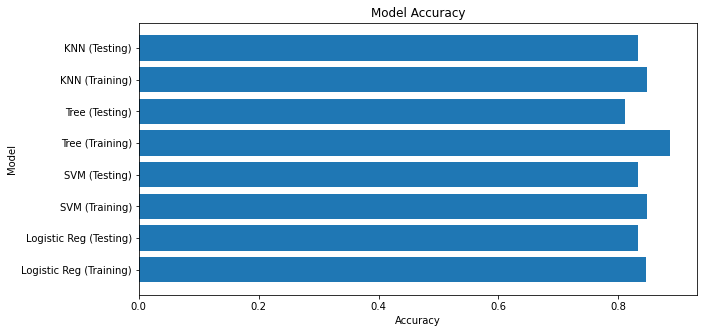

In [225]:
data = {'Logistic Reg (Training)':0.8464285714285713,'Logistic Reg (Testing)':0.8333333333333334, 'SVM (Training)':0.8482142857142856,'SVM (Testing)':0.8333333333333334, 'Tree (Training)':0.8866428571428574,'Tree (Testing)':0.8105555555555555,'KNN (Training)':0.8482142857142858,'KNN (Testing)':0.8333333333333334
}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(courses, values)
 
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

As we can see, the tree model is, on average, slightly better at eliminating false positives than the other models. And with a success rate comparable to the other models (81 vs 83), I believe the tree model to be the best.